In [101]:
import numpy as np
import scipy.sparse as sp
import torch
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math 
from torch.nn import Linear
from torch.nn.parameter import Parameter
import torch_geometric
from torch_geometric.datasets import UPFD
from torch.nn.modules.module import Module
from torch_geometric.transforms import BaseTransform, Compose, NormalizeFeatures,ToUndirected
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool
from torch_geometric.transforms import ToUndirected

In [102]:
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [103]:
seed = 1997
np.random.seed(seed)
torch.manual_seed(seed)

UPFD Dataset

name can be:    

- "politifact" or 
- "gossipcop"

feature can be: 

- "profile":  10 dimensional user profile attributes
- "spacy"  : 300 dimensional word2vec encoding historical tweets 
- "bert"   : 768 dimensional BERT encoding historical tweets 
- "content": 310 dimensional composed by "spacy" + "profile"

spit can be:

- train 
- val 
- test 

nel caso in cui il comando 
'UPFD(root="data", name="politifact", feature="content")' dia errore, 
per scarica manualemente il dataset:

1. clicca sul link di download presente nell'errore 
2. scaricare il file zip 
3. estrarre il file zip 
4. spostare il contenuto (e.g. text_idx.npy etc) nella cartella polifact/raw/
5. chiamare di nuovo UPFD(root="data", name="politifact", feature="content"), 
verrà creata automaticamente una cartella "processed"

In [104]:
from typing import Any


class graph_filter:
    def __call__(self, data, *args: Any, **kwds: Any) -> Any:
        return data.edge_index.shape[1] == 0
    
    

In [122]:
from collections import namedtuple
conf = namedtuple("conf", ["NAME", "FEATURE"])("politifact", "content")

In [126]:
import argparse

In [127]:
args = argparse.Namespace()

In [316]:
args.PATH = "data"
args.NAME = "politifact"
args.FEATURE = "content"
args.BATCH_SIZE = 16

In [317]:
path = "data" # osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data')
train_dataset = UPFD(path, args.NAME, args.FEATURE, 'train')
val_dataset = UPFD(path, args.NAME, args.FEATURE, 'val')
test_dataset = UPFD(path, args.NAME, args.FEATURE, 'test')

print("len train_dataset:", len(train_dataset))
print("len val_dataset:", len(val_dataset))
print("len test_dataset:", len(test_dataset))

train_loader = DataLoader(train_dataset,
                           batch_size=args.BATCH_SIZE, 
                           shuffle=True,
                           )
val_loader = DataLoader(val_dataset,
                           batch_size=args.BATCH_SIZE, 
                           shuffle=False,
                           
                           )
test_loader = DataLoader(test_dataset,
                           batch_size=args.BATCH_SIZE, 
                           shuffle=False,
                           )


len train_dataset: 62
len val_dataset: 31
len test_dataset: 221


In [318]:

# sample.x tensor of shape (6883, 768) where 6883 is the sum of ALL nodes in the batch, and 768 is the dimesion
# sample.edge_index tensor of shape (2,2) 
# sample.batch intero da 0 a BATCH_SIZE che indica per ogni nodo a quale batch appartiene 
# sample.y tensor of shape BATCH_SIZE with values 0 or 1 indicating the labels 

In [319]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}') 

Using device: cpu


In [320]:
def plots(loss_train_history,loss_valid_history,acc__valid_history,acc__test__history,model_desc):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].plot(loss_train_history, label = 'train') 
    axs[0].plot(loss_valid_history, label = 'val') 
    axs[0].legend()
    axs[0].set_title('loss')
    axs[0].set_xlabel('epochs')
    axs[0].grid()
    nbins = int(((len(loss_train_history) + 1 ) / 10)*2 + 2 )
    axs[0].locator_params(axis='both', nbins=nbins) 

    axs[1].plot(acc__valid_history,label = 'val_accuracy')
    axs[1].plot(acc__test__history,label = 'test_accuracy')
    axs[1].set_title('accuracy')
    axs[1].set_xlabel('epochs')
    axs[1].legend()
    axs[1].grid()
    axs[1].locator_params(axis='both', nbins=nbins) 

    fig.suptitle(model_desc, fontsize=10)

In [321]:
def train(model, optimizer):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader, model):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

@torch.no_grad()
def compute_val_loss(loader, model):
    model.eval()

    total_loss = 0 
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        test_loss = F.nll_loss(out, data.y)
        total_loss += float(test_loss) * data.num_graphs
    return total_loss / len(loader.dataset)



In [322]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 concat=False):
        super().__init__()
        self.concat = concat
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.norm1 = torch_geometric.nn.BatchNorm(in_channels=hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.norm2 = torch_geometric.nn.BatchNorm(in_channels=hidden_channels)
        self.act = torch.nn.ReLU()
        if self.concat:
            self.lin0 = Linear(in_channels, hidden_channels)
            self.lin1 = Linear(2 * hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = self.norm1(h)
        h = self.act(h)
        h = self.conv2(h, edge_index)
        h = self.norm2(h)
        h = self.act(h)
        h = global_max_pool(h, batch)

        if self.concat:
            # Get the root node (tweet) features of each graph:
            root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
            root = torch.cat([root.new_zeros(1), root + 1], dim=0)
            news = x[root]

            news = self.lin0(news).relu()
            h = self.lin1(torch.cat([news, h], dim=-1)).relu()

        h = self.lin2(h)
        return h.log_softmax(dim=-1)



In [333]:

model = Net(train_dataset.num_features, args.HIDDEN_CHANNEL,
            train_dataset.num_classes, concat=True).to(device)
model

Net(
  (conv1): GCNConv(310, 64)
  (norm1): BatchNorm(64)
  (conv2): GCNConv(64, 64)
  (norm2): BatchNorm(64)
  (act): ReLU()
  (lin0): Linear(in_features=310, out_features=64, bias=True)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [334]:
#args.MODE = "only_BN_FC"
args.MODE = "ALL"

if args.MODE == "only_BN_FC":
    for param in model.parameters():
        param.requires_grad = False

    for param in model.norm1.parameters():
        param.requires_grad = True 


    for param in model.norm2.parameters():
        param.requires_grad = True

    for param in model.lin2.parameters():
        param.requires_grad = True 

if args.MODE == "only_BN":
    for param in model.parameters():
        param.requires_grad = False

    for param in model.norm1.parameters():
        param.requires_grad = True 


    for param in model.norm2.parameters():
        param.requires_grad = True

 

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name) 

conv1.bias
conv1.lin.weight
norm1.module.weight
norm1.module.bias
conv2.bias
conv2.lin.weight
norm2.module.weight
norm2.module.bias
lin0.weight
lin0.bias
lin1.weight
lin1.bias
lin2.weight
lin2.bias


In [340]:
args.weight_decay = 0.01
args.LR = 3e-5
optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, weight_decay=args.weight_decay)

In [341]:
model_desc = str(vars(args))
model_desc

"{'PATH': 'data', 'NAME': 'politifact', 'FEATURE': 'content', 'BATCH_SIZE': 16, 'LR': 3e-05, 'HIDDEN_CHANNEL': 64, 'MODE': 'ALL', 'weight_decay': 0.01}"

In [342]:
loss_train_history = []
loss_valid_history = []
acc__train_history = []
acc__valid_history = []
acc__test__history = []

In [343]:
NUMS_EPOCHS = 300   
for epoch in range(1, NUMS_EPOCHS):
    loss = train(model, optimizer)
    train_acc = test(train_loader,model)
    val_acc = test(val_loader,model)
    test_acc = test(test_loader,model)
    val_loss = compute_val_loss(val_loader,model)
    print(f'Epoch: {epoch:02d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    loss_train_history.append(loss)
    loss_valid_history.append(val_loss)
    acc__train_history.append(train_acc)
    acc__valid_history.append(val_acc)
    acc__test__history.append(test_acc)

Epoch: 01, Train Loss: 0.5475, Val Loss: 0.7336, Train: 0.8871, Val: 0.4516, Test: 0.5339
Epoch: 02, Train Loss: 0.5446, Val Loss: 0.7329, Train: 0.8871, Val: 0.4516, Test: 0.5385
Epoch: 03, Train Loss: 0.5484, Val Loss: 0.7305, Train: 0.9355, Val: 0.4516, Test: 0.5566
Epoch: 04, Train Loss: 0.5391, Val Loss: 0.7300, Train: 0.9355, Val: 0.4839, Test: 0.5611
Epoch: 05, Train Loss: 0.5388, Val Loss: 0.7298, Train: 0.9355, Val: 0.4839, Test: 0.5611
Epoch: 06, Train Loss: 0.5354, Val Loss: 0.7298, Train: 0.9355, Val: 0.4839, Test: 0.5611
Epoch: 07, Train Loss: 0.5358, Val Loss: 0.7292, Train: 0.9355, Val: 0.4839, Test: 0.5656
Epoch: 08, Train Loss: 0.5283, Val Loss: 0.7274, Train: 0.9355, Val: 0.4839, Test: 0.5656
Epoch: 09, Train Loss: 0.5236, Val Loss: 0.7271, Train: 0.9355, Val: 0.4839, Test: 0.5656
Epoch: 10, Train Loss: 0.5221, Val Loss: 0.7277, Train: 0.9355, Val: 0.4839, Test: 0.5656
Epoch: 11, Train Loss: 0.5237, Val Loss: 0.7283, Train: 0.9355, Val: 0.4839, Test: 0.5656
Epoch: 12,

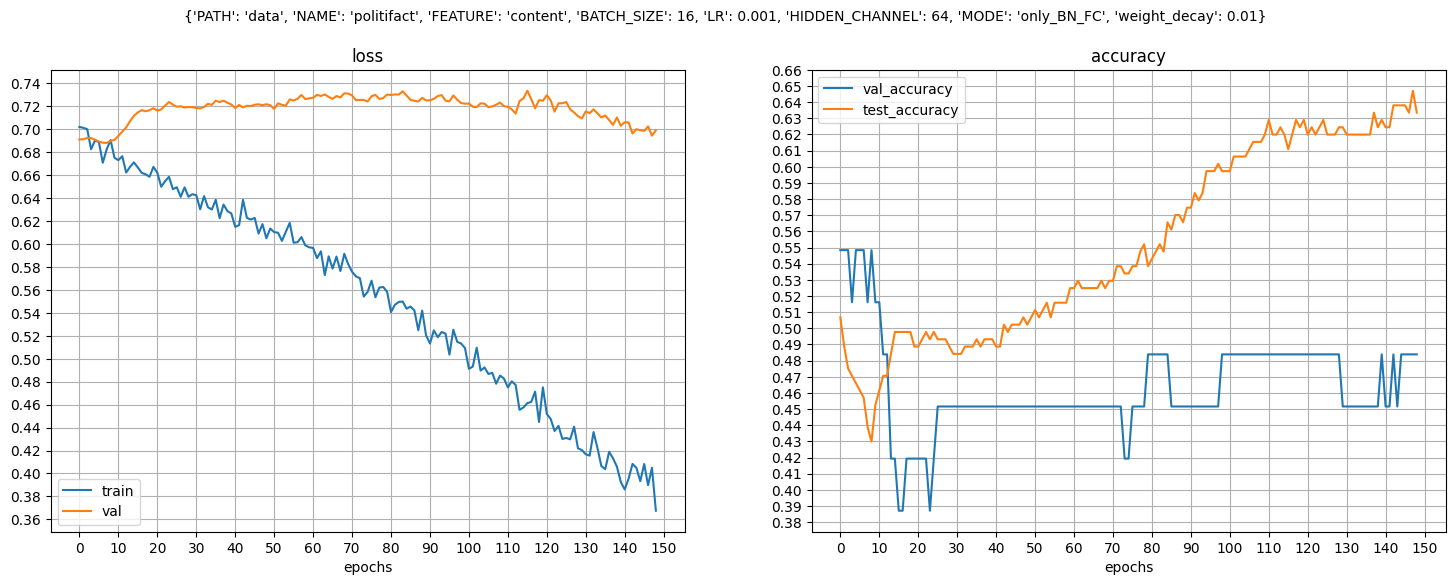

In [233]:
plots(loss_train_history,loss_valid_history,acc__valid_history,acc__test__history,model_desc)

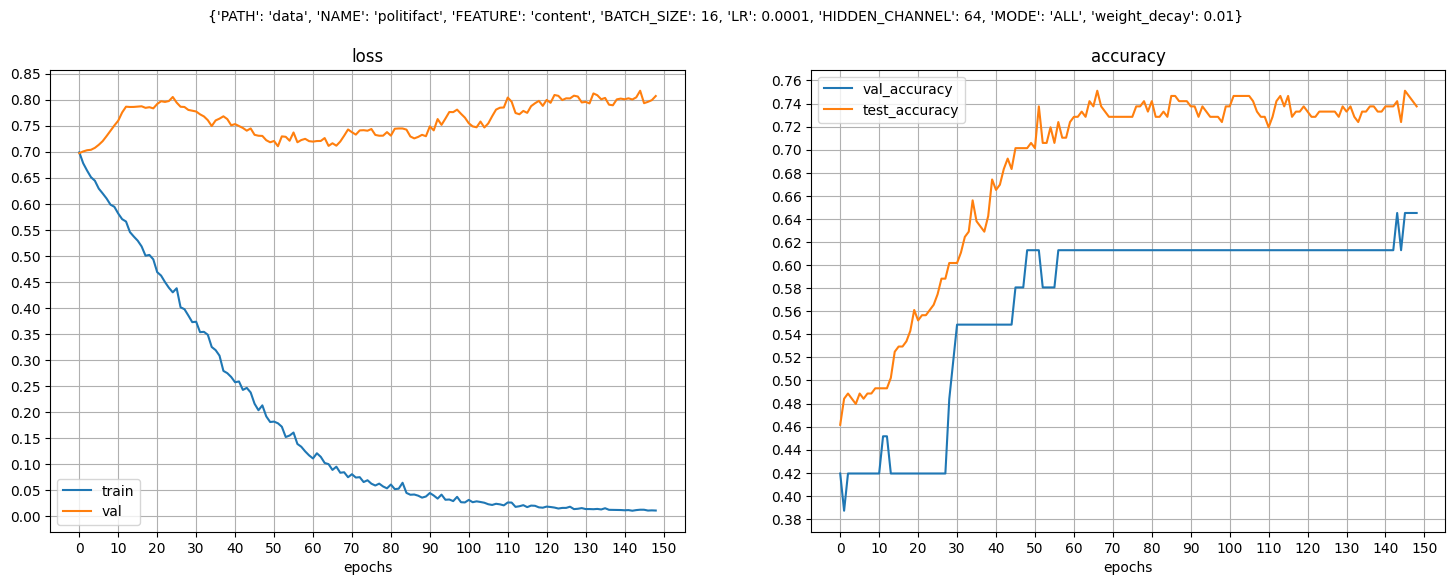

In [330]:
plots(loss_train_history,loss_valid_history,acc__valid_history,acc__test__history,model_desc)

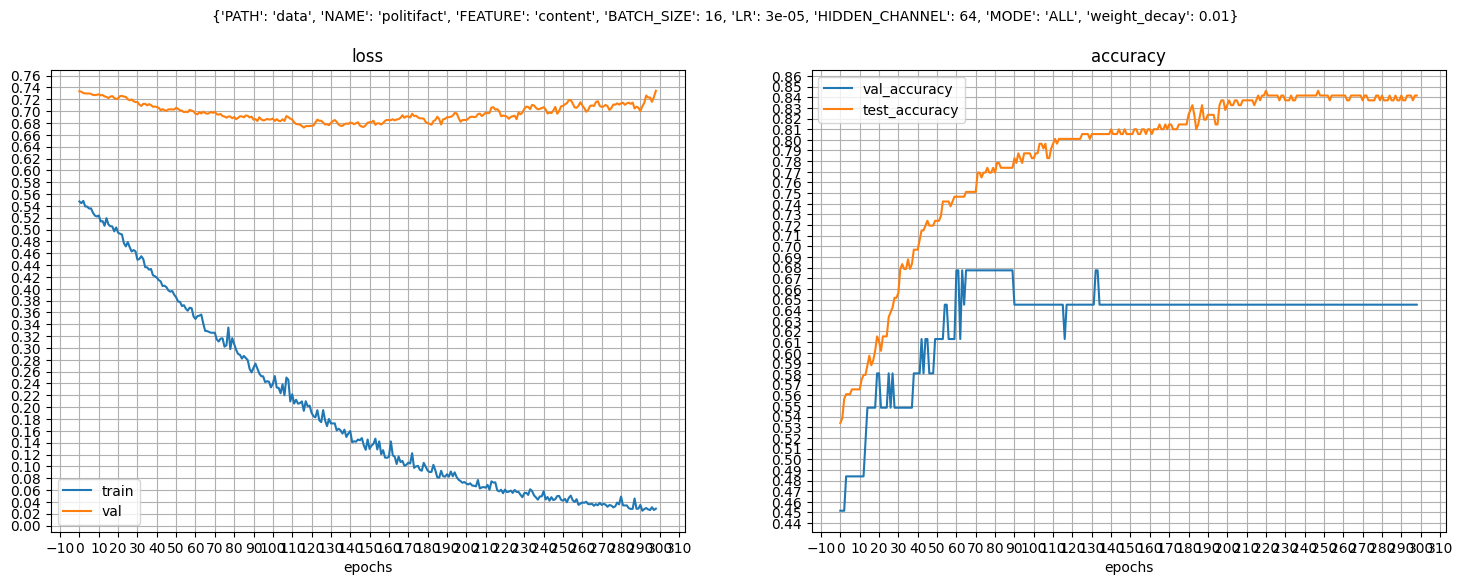

In [344]:
plots(loss_train_history,loss_valid_history,acc__valid_history,acc__test__history,model_desc)

In [360]:
histories = []


In [361]:
histories.append({"mode":args.MODE,
    "args":args, 
             "loss_train_history":loss_train_history,
             "loss_valid_history":loss_valid_history,
             "acc__valid_history":acc__valid_history,
             "acc__test__history":acc__test__history,
             })

In [358]:
train_all = {"args":args, 
             "loss_train_history":loss_train_history,
             "loss_valid_history":loss_valid_history,
             "acc__valid_history":acc__valid_history,
             "acc__test__history":acc__test__history,
             }

In [283]:
print("train all")
bn1_weigh, bn1_bias = [p.detach().numpy() for p in model.norm1.parameters()]
bn2_weigh, bn2_bias = [p.detach().numpy() for p in model.norm2.parameters()]

print(bn1_weigh.mean())
print(bn1_weigh.std())
print()
print(bn2_weigh.mean())
print(bn2_bias.std())

train all
0.51144457
0.018572798

0.53908855
0.0057418207


In [347]:
import seaborn as sns

In [264]:
print("train only BN and last layer")
bn1_weigh, bn1_bias = [p.detach().numpy() for p in model.norm1.parameters()]
bn2_weigh, bn2_bias = [p.detach().numpy() for p in model.norm2.parameters()]

print(bn1_weigh.mean())
print(bn1_weigh.std())
print()
print(bn2_weigh.mean())
print(bn2_bias.std())

train only BN and last layer
0.594815
0.12922907

0.6903192
0.100634426


In [ ]:
print(args)
title = "Training on batch norm \n Distribution of Batch Norm weights parameter"
sns.set_style("white")
ax = sns.histplot(np.concatenate([bn1_weigh,bn2_weigh]), stat="percent")
ax.set_title(title)
ax.set_xlabel("weights values")

Namespace(PATH='data', NAME='politifact', FEATURE='content', BATCH_SIZE=16, LR=3e-05, HIDDEN_CHANNEL=64, MODE='ALL', weight_decay=0.01)


Text(0.5, 0, 'weights values')

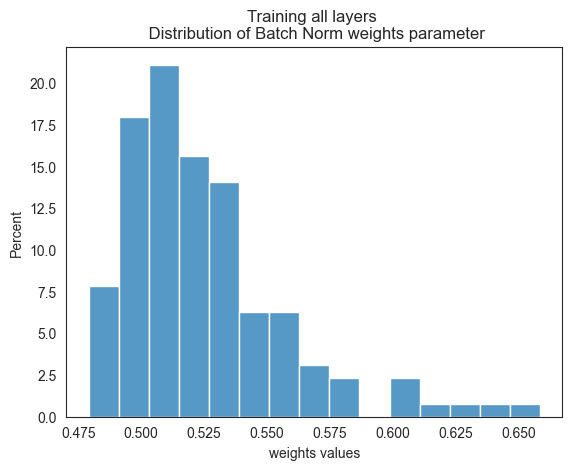

In [357]:
print(args)
title = "Training all layers \n Distribution of Batch Norm weights parameter"
sns.set_style("white")
ax = sns.histplot(np.concatenate([bn1_weigh,bn2_weigh]), stat="percent")
ax.set_title(title)
ax.set_xlabel("weights values")

Namespace(PATH='data', NAME='politifact', FEATURE='content', BATCH_SIZE=16, LR=0.001, HIDDEN_CHANNEL=64, MODE='only_BN_FC', weight_decay=0.01)


[]

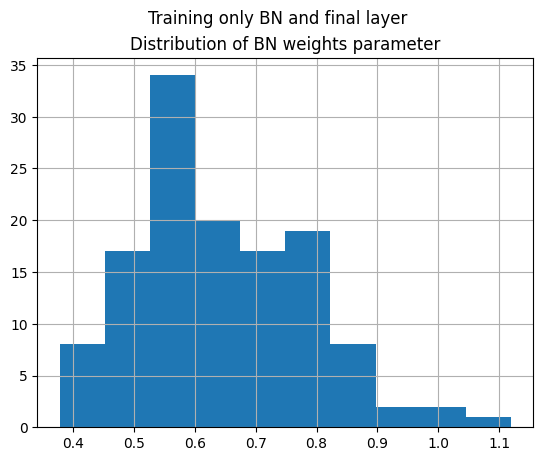

In [263]:
print(args)
fig, ax = plt.subplots()
ax.grid()
ax.hist(np.concatenate([bn1_weigh,bn2_weigh]))
ax.set_title("Distribution of BN weights parameter")
fig.suptitle("Training only BN and final layer")
plt.plot()

In [235]:
for p in model.norm1.parameters():
    print(p)

for p in model.norm2.parameters():
    print(p)

Parameter containing:
tensor([0.7229, 0.5009, 0.7363, 0.5682, 0.4900, 0.5803, 0.8553, 0.4379, 0.7159,
        0.7321, 0.7565, 0.7799, 0.4889, 0.6113, 0.6228, 0.5823, 0.8308, 0.5399,
        0.7369, 0.5323, 0.4030, 0.5773, 0.7454, 0.5353, 0.5507, 0.6960, 0.5982,
        0.4096, 0.5447, 0.4600, 0.7792, 0.6322, 0.8376, 0.5760, 0.5974, 0.5456,
        0.6847, 0.5063, 0.4106, 0.4623, 0.5214, 0.5256, 0.5633, 0.5011, 0.6451,
        0.8112, 0.5673, 0.5591, 0.5336, 0.5726, 0.6398, 0.5566, 0.4281, 0.3778,
        0.5442, 0.6391, 0.5693, 0.7932, 0.4696, 0.9848, 0.5103, 0.4084, 0.5274,
        0.4456], requires_grad=True)
Parameter containing:
tensor([ 2.1047e-01,  2.6987e-01,  5.6806e-02, -2.1036e-01,  2.5082e-03,
        -8.9281e-02,  7.9798e-02, -1.7996e-01,  1.7649e-01,  1.3990e-01,
        -1.7890e-01,  7.9250e-02, -2.5033e-01,  6.1614e-02,  2.1468e-01,
         1.1821e-02,  5.3123e-02,  1.3425e-01,  1.3535e-01, -2.9080e-01,
        -4.2523e-01,  5.5886e-02,  1.9022e-01, -1.7310e-01, -1.3200

In [ ]:
# data gossip content 
# train bn + last fc 

In [ ]:
# data politict fact bert 
# train bn + last fc 
Epoch: 56, Train Loss: 0.5658, Val Loss: 0.7335, Train: 0.7258, Val: 0.3871, Test: 0.6290
Epoch: 57, Train Loss: 0.5638, Val Loss: 0.7331, Train: 0.7258, Val: 0.3871, Test: 0.6290
Epoch: 58, Train Loss: 0.5618, Val Loss: 0.7328, Train: 0.7258, Val: 0.4194, Test: 0.6290
Epoch: 59, Train Loss: 0.5598, Val Loss: 0.7326, Train: 0.7258, Val: 0.4194, Test: 0.6290

# train only fc 

Epoch: 56, Train Loss: 0.6323, Val Loss: 0.6965, Train: 0.5968, Val: 0.4516, Test: 0.5068
Epoch: 57, Train Loss: 0.6314, Val Loss: 0.6957, Train: 0.6129, Val: 0.4516, Test: 0.5068
Epoch: 58, Train Loss: 0.6305, Val Loss: 0.6950, Train: 0.6129, Val: 0.4516, Test: 0.5068
Epoch: 59, Train Loss: 0.6296, Val Loss: 0.6944, Train: 0.6129, Val: 0.4516, Test: 0.5068

# train all 

Epoch: 56, Train Loss: 0.0006, Val Loss: 0.3847, Train: 1.0000, Val: 0.7742, Test: 0.8281
Epoch: 57, Train Loss: 0.0006, Val Loss: 0.3874, Train: 1.0000, Val: 0.7742, Test: 0.8281
Epoch: 58, Train Loss: 0.0006, Val Loss: 0.3900, Train: 1.0000, Val: 0.7742, Test: 0.8281
Epoch: 59, Train Loss: 0.0006, Val Loss: 0.3924, Train: 1.0000, Val: 0.7742, Test: 0.8281


In [ ]:
# dataset politict fact content 
# train only last fc 
Epoch: 56, Train Loss: 0.6523, Val Loss: 0.9104, Train: 0.5806, Val: 0.2581, Test: 0.4163
Epoch: 57, Train Loss: 0.6499, Val Loss: 0.9099, Train: 0.5806, Val: 0.2581, Test: 0.4163
Epoch: 58, Train Loss: 0.6475, Val Loss: 0.9089, Train: 0.5968, Val: 0.2581, Test: 0.4208
Epoch: 59, Train Loss: 0.6452, Val Loss: 0.9078, Train: 0.5968, Val: 0.2581, Test: 0.4118

# train all
Epoch: 45, Train Loss: 0.0104, Val Loss: 0.5164, Train: 1.0000, Val: 0.7419, Test: 0.8416
Epoch: 46, Train Loss: 0.0101, Val Loss: 0.5163, Train: 1.0000, Val: 0.7419, Test: 0.8371
Epoch: 47, Train Loss: 0.0097, Val Loss: 0.5166, Train: 1.0000, Val: 0.7742, Test: 0.8416
Epoch: 48, Train Loss: 0.0094, Val Loss: 0.5172, Train: 1.0000, Val: 0.7742, Test: 0.8507
Epoch: 49, Train Loss: 0.0091, Val Loss: 0.5181, Train: 1.0000, Val: 0.7742, Test: 0.8507

# train only bn 

Epoch: 56, Train Loss: 0.7433, Val Loss: 0.7447, Train: 0.5000, Val: 0.6129, Test: 0.4615
Epoch: 57, Train Loss: 0.7424, Val Loss: 0.7458, Train: 0.5000, Val: 0.6129, Test: 0.4615
Epoch: 58, Train Loss: 0.7415, Val Loss: 0.7468, Train: 0.5000, Val: 0.6129, Test: 0.4615
Epoch: 59, Train Loss: 0.7406, Val Loss: 0.7478, Train: 0.5000, Val: 0.6129, Test: 0.4615

# train bn and final fc 
Epoch: 56, Train Loss: 0.6284, Val Loss: 0.7733, Train: 0.6935, Val: 0.4194, Test: 0.5068
Epoch: 57, Train Loss: 0.6275, Val Loss: 0.7748, Train: 0.6935, Val: 0.4194, Test: 0.5113
Epoch: 58, Train Loss: 0.6265, Val Loss: 0.7763, Train: 0.6935, Val: 0.4194, Test: 0.5113
Epoch: 59, Train Loss: 0.6256, Val Loss: 0.7777, Train: 0.6935, Val: 0.4194, Test: 0.5158

In [ ]:
# 1 deep GAT con batch norm 
Epoch: 44, Train Loss: 0.0344, Val Loss: 0.0848, Train: 0.9936, Val: 0.9689, Test: 0.9726
Epoch: 45, Train Loss: 0.0324, Val Loss: 0.0839, Train: 0.9945, Val: 0.9689, Test: 0.9733
Epoch: 46, Train Loss: 0.0305, Val Loss: 0.0832, Train: 0.9954, Val: 0.9689, Test: 0.9736


# 1. senza bn 
Epoch: 45, Train Loss: 0.0792, Val Loss: 0.1078, Train: 0.9744, Val: 0.9652, Test: 0.9702
Epoch: 46, Train Loss: 0.0789, Val Loss: 0.1075, Train: 0.9744, Val: 0.9652, Test: 0.9705
Epoch: 47, Train Loss: 0.0785, Val Loss: 0.1072, Train: 0.9744, Val: 0.9652, Test: 0.9705
Epoch: 48, Train Loss: 0.0782, Val Loss: 0.1072, Train: 0.9744, Val: 0.9652, Test: 0.9705
Epoch: 49, Train Loss: 0.0778, Val Loss: 0.1072, Train: 0.9744, Val: 0.9652, Test: 0.9702


# 2. con bn 
Epoch: 15, Train Loss: 0.0311, Val Loss: 0.0980, Train: 0.9954, Val: 0.9652, Test: 0.9663
Epoch: 16, Train Loss: 0.0243, Val Loss: 0.0970, Train: 0.9991, Val: 0.9634, Test: 0.9665
Epoch: 17, Train Loss: 0.0190, Val Loss: 0.0962, Train: 0.9991, Val: 0.9634, Test: 0.9663
Epoch: 18, Train Loss: 0.0149, Val Loss: 0.0955, Train: 1.0000, Val: 0.9634, Test: 0.9671
Epoch: 19, Train Loss: 0.0118, Val Loss: 0.0954, Train: 1.0000, Val: 0.9634, Test: 0.9665

Epoch: 46, Train Loss: 0.0015, Val Loss: 0.1096, Train: 1.0000, Val: 0.9652, Test: 0.9665
Epoch: 47, Train Loss: 0.0016, Val Loss: 0.1144, Train: 1.0000, Val: 0.9634, Test: 0.9663
Epoch: 48, Train Loss: 0.0015, Val Loss: 0.1161, Train: 1.0000, Val: 0.9615, Test: 0.9660
Epoch: 49, Train Loss: 0.0014, Val Loss: 0.1123, Train: 1.0000, Val: 0.9670, Test: 0.9679

# hidden 64 ln 
Epoch: 56, Train Loss: 0.0326, Val Loss: 0.1144, Train: 0.9945, Val: 0.9652, Test: 0.9642
Epoch: 57, Train Loss: 0.0309, Val Loss: 0.1145, Train: 0.9954, Val: 0.9634, Test: 0.9645
Epoch: 58, Train Loss: 0.0293, Val Loss: 0.1144, Train: 0.9963, Val: 0.9634, Test: 0.9645
Epoch: 59, Train Loss: 0.0279, Val Loss: 0.1140, Train: 0.9963, Val: 0.9634, Test: 0.9647

# con ln 
Epoch: 56, Train Loss: 0.0120, Val Loss: 0.1227, Train: 1.0000, Val: 0.9670, Test: 0.9634
Epoch: 57, Train Loss: 0.0115, Val Loss: 0.1231, Train: 1.0000, Val: 0.9670, Test: 0.9637
Epoch: 58, Train Loss: 0.0110, Val Loss: 0.1237, Train: 1.0000, Val: 0.9670, Test: 0.9637
Epoch: 59, Train Loss: 0.0104, Val Loss: 0.1249, Train: 1.0000, Val: 0.9689, Test: 0.9645


# deep GCN + layer norm 
Epoch: 46, Train Loss: 0.0813, Val Loss: 0.1252, Train: 0.9771, Val: 0.9542, Test: 0.9595
Epoch: 47, Train Loss: 0.0774, Val Loss: 0.1237, Train: 0.9789, Val: 0.9542, Test: 0.9603
Epoch: 48, Train Loss: 0.0734, Val Loss: 0.1221, Train: 0.9799, Val: 0.9597, Test: 0.9600
Epoch: 49, Train Loss: 0.0698, Val Loss: 0.1206, Train: 0.9808, Val: 0.9615, Test: 0.9608



## train with batch norm 